## PINNs for Steady Cavity Problem

Solving the 2D steady diffusion equation using a Physics Informed Neural Network (PINN).  

### Governing Equations

The equations for the 2D steady Navier-Stokes problem are given by:

$$
\begin{cases}
\cancel{\frac{\partial u}{\partial t}} + u \frac{\partial u}{\partial x} + v \frac{\partial u}{\partial y} = -\frac{1}{\rho} \frac{\partial p}{\partial x} + \nu \left( \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} \right)  \\
\cancel{\frac{\partial v}{\partial t}} + u \frac{\partial v}{\partial x} + v \frac{\partial v}{\partial y} = -\frac{1}{\rho} \frac{\partial p}{\partial y} + \nu \left( \frac{\partial^2 v}{\partial x^2} + \frac{\partial^2 v}{\partial y^2} \right)
\end{cases}
$$



### Continuity Equation

The continuity equation for incompressible flow is:

$$
\frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} = 0
$$

### Momentum Equations

In terms of the components, the momentum equations are:

$$
u \frac{\partial u}{\partial x} + v \frac{\partial u}{\partial y} + \frac{\partial p}{\partial x} = \frac{1}{Re} \left( \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} \right)
$$

$$
u \frac{\partial v}{\partial x} + v \frac{\partial v}{\partial y} + \frac{\partial p}{\partial y} = \frac{1}{Re} \left( \frac{\partial^2 v}{\partial x^2} + \frac{\partial^2 v}{\partial y^2} \right)
$$

where \( Re \) is the Reynolds number.

### Domain

The domain for x and y is:
$$
 x \in [0,1] \quad \text{and } \quad  y \in [0,1] .
$$

### Initial and Boundary Conditions

The boundary conditions (BCs) for this problem are as follows:

- For \( u \) and \( v \):

$$
u(0, y) = 0 \quad \text{for } y \in [0, 1]
$$

$$
u(1, y) = 0 \quad \text{for } y \in [0, 1]
$$

$$
u(x, 0) = 0 \quad \text{for } x \in [0, 1]
$$

$$
u(x, 1) = u_i \quad \text{for } x \in [0, 1] \quad (u_i \text{ is the top wall's velocity})
$$

$$
v(0, y) = 0 \quad \text{for } y \in [0, 1]
$$

$$
v(1, y) = 0 \quad \text{for } y \in [0, 1]
$$

$$
v(x, 0) = 0 \quad \text{for } x \in [0, 1]
$$

$$
v(x, 1) = 0 \quad \text{for } x \in [0, 1]
$$

### Loss Function for PINN

In the context of a Physics Informed Neural Network (PINN), the loss function includes terms to enforce these equations and boundary conditions:

- Residuals of the Navier-Stokes equations and continuity equation.
- Boundary conditions for \( u \) and \( v \).

The loss function can be represented as:

$$
\text{Loss} = \text{Loss}{\text{equations}} + \text{Loss}{\text{boundary conditions}}
$$

Where:
- $ \text{Loss}_{\text{equations}} $ ensures that the predicted solutions satisfy the Navier-Stokes and continuity equations.
- $ \text{Loss}_{\text{boundary conditions}} $ ensures that the boundary conditions are met.


In [1]:
import torch
import torch.nn as nn
from torch.autograd import grad
import torch.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda:1")     # NVIDIA GPUs
elif torch.backends.mps.is_available():
    device = torch.device("mps")        # Apple silicon (metal performance shaders)
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: cpu


### Define PINNs network class with Fourier Feature Mapping

In [3]:
class ffm(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.B = nn.Parameter(torch.normal(mean=0, std=10, size=(in_dim, out_dim), requires_grad=False))
    
    def forward(self, x):
        x_map = torch.matmul(x, self.B)
        return torch.cat([torch.cos(x_map), torch.sin(x_map)], -1)

class PINNs_net(nn.Module):    
    def __init__(self, in_dim=2, HL_dim=64, out_dim=3, activation=nn.Tanh()):
        super().__init__()

        network = [ffm(in_dim, HL_dim),
                   nn.Linear(HL_dim*2, HL_dim), activation,
                   nn.Linear(HL_dim, HL_dim), activation,
                   nn.Linear(HL_dim, HL_dim), activation,
                   nn.Linear(HL_dim, HL_dim), activation,
                   nn.Linear(HL_dim, out_dim)]
        
        # define the network using sequential method
        self.net = nn.Sequential(*network) 
        
    def forward(self, x, y):
        return self.net(torch.cat((x, y), 1))
    

    def compute_loss(self, x, y, Nx, Ny, u_i):
        """
        This is the physics part really
        """
        Re = 100
        x.requires_grad=True
        y.requires_grad=True
        net_out = self.net(torch.cat((x,y), 1))   # input size: [Nx*Ny,2], output size: [Nx*Ny,3]

        u = net_out[:,0]
        v = net_out[:,1]
        p = net_out[:,2]
 
        u_x = grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_y = grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_xx = grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
        u_yy = grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]

        v_x = grad(v, x, grad_outputs=torch.ones_like(v), create_graph=True)[0]  # Change 5: Added gradients for v
        v_y = grad(v, y, grad_outputs=torch.ones_like(v), create_graph=True)[0]
        v_xx = grad(v_x, x, grad_outputs=torch.ones_like(v_x), create_graph=True)[0]
        v_yy = grad(v_y, y, grad_outputs=torch.ones_like(v_y), create_graph=True)[0]

        p_x = grad(p, x, grad_outputs=torch.ones_like(p), create_graph=True)[0]
        p_y = grad(p, y, grad_outputs=torch.ones_like(p), create_graph=True)[0]

        # set a loss function to apply to each of the physics residuals (PDE, IC, BC)
        loss_fun = nn.MSELoss()

        # compute the PDE residual loss
        res1 = u_x + v_y
        res2 = u*u_x + v*u_y + p_x - 1/Re*(u_xx+u_yy)
        res3 = u*v_x + v*v_y + p_y - 1/Re*(v_xx+v_yy)
        pde_loss = loss_fun(res1, torch.zeros_like(res1)) + loss_fun(res2, torch.zeros_like(res2)) + loss_fun(res3, torch.zeros_like(res3))

        # compute the BC loss
        u_reshaped = u.view(Nx, Ny) # [Nx*Ny, 1] -> [Nx, Ny]
        v_reshaped = v.view(Nx, Ny) # [Nx*Ny, 1] -> [Nx, Ny]

        # Calculate indices for the boundary condition range
        bc_loss = loss_fun(u_reshaped[0, :], torch.zeros_like(u_reshaped[0,:])) \
                + loss_fun(u_reshaped[-1, :], torch.zeros_like(u_reshaped[Nx-1,:])) \
                + loss_fun(v_reshaped[0, :], torch.zeros_like(v_reshaped[0,:])) \
                + loss_fun(v_reshaped[-1, :], torch.zeros_like(v_reshaped[Nx-1,:])) \
                + loss_fun(u_reshaped[:, 0], torch.zeros_like(u_reshaped[:,Ny-1])) \
                + loss_fun(v_reshaped[:,0], torch.zeros_like(v_reshaped[:,Ny-1])) \
                + loss_fun(u_reshaped[:, -1], torch.ones_like(u_reshaped[:, -1]) * u_i) \
                + loss_fun(v_reshaped[:, -1], torch.zeros_like(v_reshaped[:, -1]))
       
        return pde_loss, bc_loss


### Define Model and Optimizer

In [4]:
model = PINNs_net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Setting up the Case

In [5]:
# num of points in the domain
Nx, Ny = 200, 200
u_i = 5 #m/s
# define domain dimensions and resolution
Lx_initial, Lx_final = 0, 1
Ly_initial, Ly_final = 0, 1

dx = (Lx_final - Lx_initial) / (Nx - 1)
dy = (Ly_final - Ly_initial) / (Ny-1)

# initiallize input parameters as tensors
x = torch.zeros(Nx, Ny)
y = torch.zeros(Nx, Ny)

for i in range(Nx):
    for j in range(Ny):
        x[i,j] = Lx_initial + dx * i
        y[i,j] = Ly_initial + dy * j


x = x.to(device)
y = y.to(device)

### Training the PINNs network

In [6]:
N_epoches = 50000
loss_per_epoch = np.zeros((N_epoches,3))
for epoch in range(N_epoches):
    # compute various losses
    eq_loss, BC_loss = model.compute_loss(x.view(-1,1), y.view(-1,1), Nx, Ny , u_i)

    # compute total loss
    total_loss = eq_loss + 10*BC_loss

    # backward pass
    total_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    loss_per_epoch[epoch,0] = eq_loss
    loss_per_epoch[epoch,1] = BC_loss
    loss_per_epoch[epoch,2] = total_loss
    print(f"epoch: {epoch}, loss: {total_loss}")


epoch: 0, loss: 242.86956787109375
epoch: 1, loss: 237.2327117919922
epoch: 2, loss: 231.93312072753906
epoch: 3, loss: 226.63890075683594
epoch: 4, loss: 221.01808166503906
epoch: 5, loss: 214.8095245361328
epoch: 6, loss: 207.842529296875
epoch: 7, loss: 200.01290893554688
epoch: 8, loss: 191.28826904296875
epoch: 9, loss: 181.73158264160156
epoch: 10, loss: 171.52630615234375
epoch: 11, loss: 160.98976135253906
epoch: 12, loss: 150.56825256347656
epoch: 13, loss: 140.78160095214844
epoch: 14, loss: 132.05197143554688
epoch: 15, loss: 124.51888275146484
epoch: 16, loss: 117.99512481689453
epoch: 17, loss: 112.06022644042969
epoch: 18, loss: 106.35660552978516
epoch: 19, loss: 100.72537231445312
epoch: 20, loss: 94.97369384765625
epoch: 21, loss: 89.02123260498047
epoch: 22, loss: 83.2181625366211
epoch: 23, loss: 77.96527099609375
epoch: 24, loss: 73.44377136230469
epoch: 25, loss: 69.67604064941406
epoch: 26, loss: 66.49951934814453
epoch: 27, loss: 63.65679168701172
epoch: 28, loss

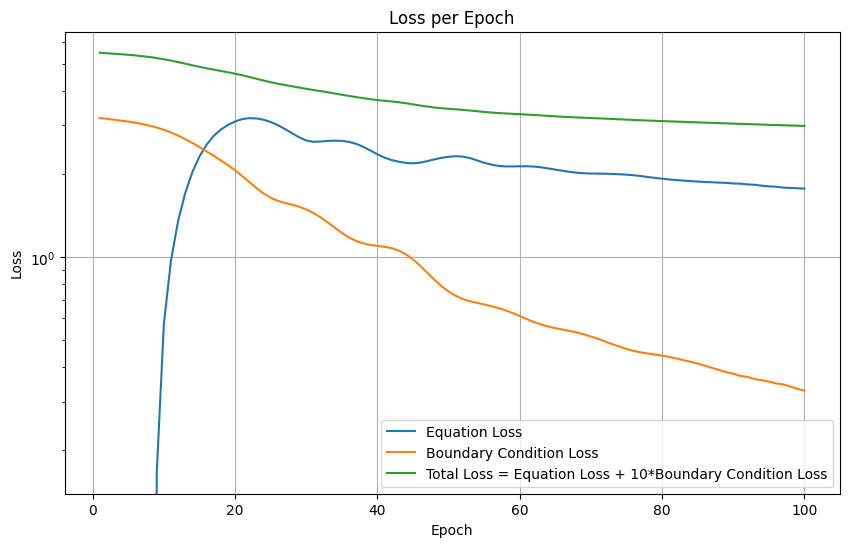

In [7]:
epocs_array = np.linspace(1,N_epoches,N_epoches)

plt.figure(figsize=(10, 6))  # Optional: specify the figure size
plt.plot(epocs_array, np.log(loss_per_epoch[:,0]), '-')
plt.plot(epocs_array, np.log(loss_per_epoch[:,1]), '-')
plt.plot(epocs_array, np.log(loss_per_epoch[:,2]), '-')

plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.grid(True) 
plt.legend(['Equation Loss','Boundary Condition Loss','Total Loss = Equation Loss + 10*Boundary Condition Loss'])

# Show the plot
plt.show()

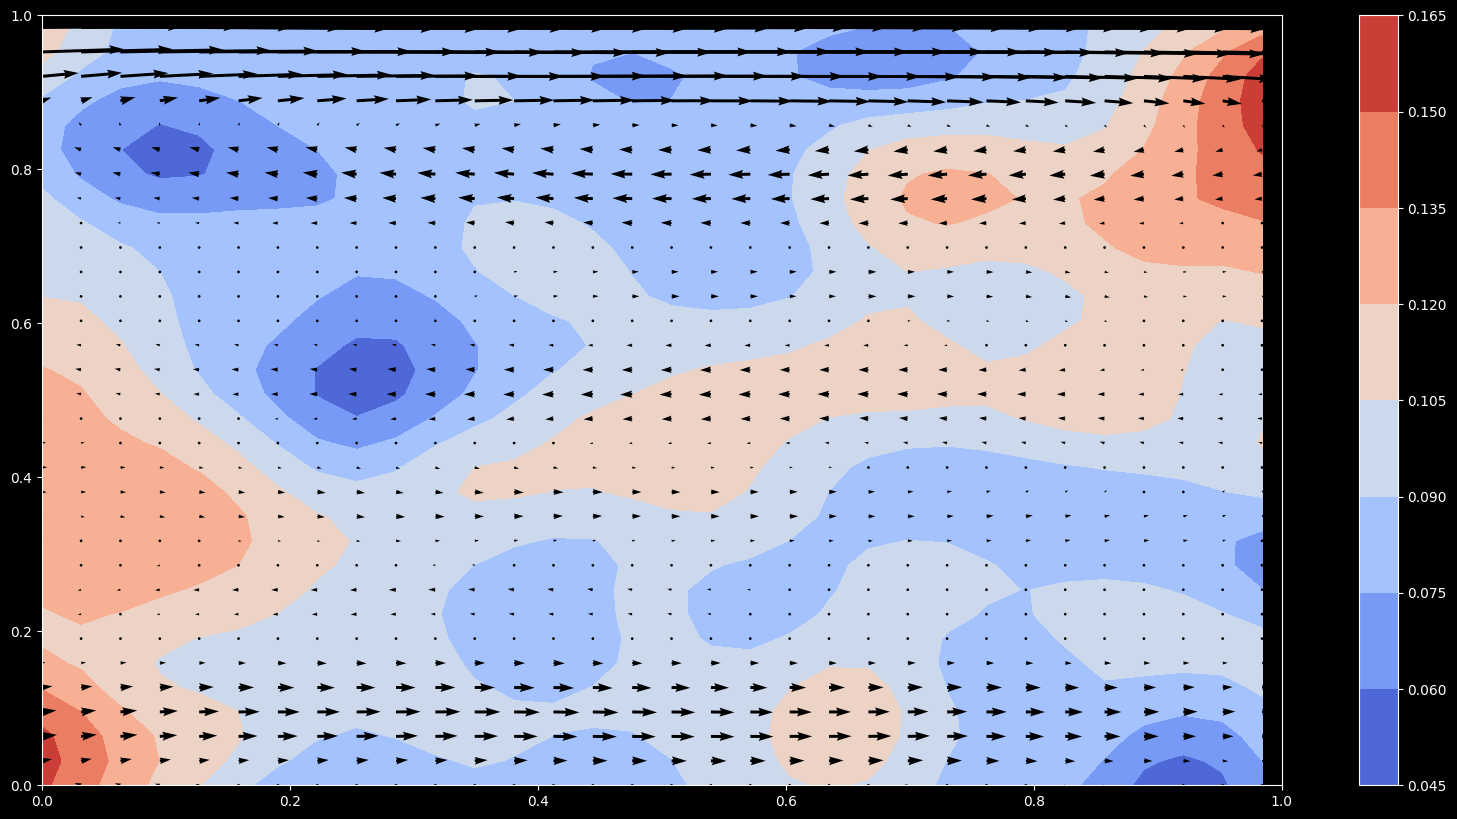

[3.4091856 3.60244   3.783992  3.9517353 4.095485  4.210313  4.2995205
 4.371036  4.432059  4.4853344 4.5301456 4.565763  4.5938296 4.617862
 4.6404223 4.6613812 4.6791115 4.692574  4.701537  4.7059646 4.706865
 4.707244  4.710506  4.7171817 4.7249007 4.732167  4.7391896 4.7443404
 4.7440543 4.7377305 4.72989   4.726672  4.73082   4.7398143 4.7486486
 4.7540727 4.7555795 4.7531056 4.745756  4.7336574 4.7196217 4.707478
 4.698405  4.6893754 4.6762557 4.6581717 4.6383834 4.6217947 4.611259
 4.6056294 4.60032   4.5889473 4.5658517 4.5285835 4.4781632 4.4171615
 4.346696  4.264451  4.165661  4.0467343 3.9090357 3.7580025 3.5967631
 3.4210207]
max u(x=0) :  2.8433173
max v(x=0) :  0.06948755


In [8]:
#  x_np, y_np = np.meshgrid(x, y)
x_np = x.detach().numpy()
y_np = y.detach().numpy()

net = model.forward(x.view(-1,1), y.view(-1,1)) # convert x tensor into a column vector
u=net[:, 0]
v=net[:, 1]
p=net[:, 2]

u_np = 1*u.detach().numpy().reshape(Nx,Ny) # convert into a np array
v_np = 1*v.detach().numpy().reshape(Nx,Ny) # convert into a np array
p_np = p.detach().numpy().reshape(Nx,Ny) # convert into a np array

# bring back the variable to the CPU for plotting
# u_np = u_np.to('cpu')
# v_np = v_np.to('cpu')
# p_np = p_np.to('cpu')

plt.style.use("dark_background")
plt.figure(figsize=(20, 10))
plt.contourf(x_np[::2,::2] , y_np[::2,::2], p_np[::2,::2], cmap="coolwarm")
plt.colorbar()


plt.quiver(x_np[::2,::2], y_np[::2,::2] , u_np[::2,::2] , v_np[::2,::2] , color="black", scale=25)
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.show()
print(u_np[:,-1])

print("max u(x=0) : " , u_np[0,1:-1].max() )
print("max v(x=0) : " , v_np[0].max() )

In [10]:
#save the data as new .npz file
np.savez('PINNs_Caviti_workspace.npz', x_np=x_np,y_np=y_np,u_np=u_np,v_np=v_np,p_np=p_np)



In [11]:
#read data from .npz file
data = np.load('PINNs_Caviti_workspace.npz')

x_read= data['x_np']
y_read= data['y_np']
u_read= data['u_np']
v_read= data['v_np']
p_read= data['p_np']
